In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

2024-09-06 14:05:14.455941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 14:05:14.551806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 14:05:14.588952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 14:05:14.606858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 14:05:14.649393: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train = pd.read_csv('train.csv')
X_train = train.drop('price', axis=1)
y_train = train['price']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=47)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=47)

<Axes: xlabel='price', ylabel='Count'>

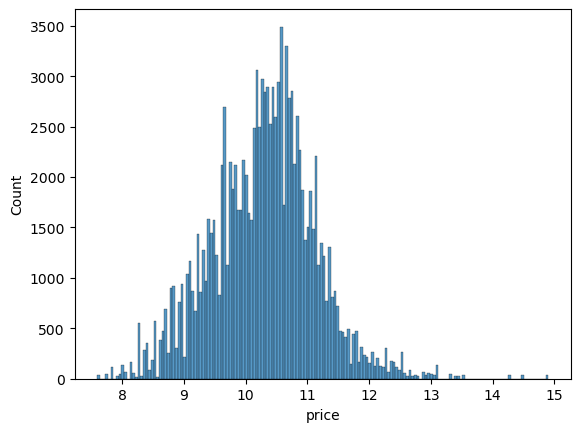

In [4]:
sns.histplot(np.log(y_train))

### Nulls

In [5]:
for col in X_train.columns:
    print(f'{col} has nulls? {X_train[col].isna().any()}')

id has nulls? False
brand has nulls? False
model has nulls? False
model_year has nulls? False
milage has nulls? False
fuel_type has nulls? True
engine has nulls? False
transmission has nulls? False
ext_col has nulls? False
int_col has nulls? False
accident has nulls? True
clean_title has nulls? True


In [6]:
X_train[X_train['fuel_type'].isna()]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
53257,53257,Ford,F-150 Lightning XLT,2023,470,NaN,563.0HP Electric Motor Electric Fuel System,A/T,White,Black,None reported,Yes
55873,55873,Tesla,Model X P90D,2022,30177,NaN,Electric Motor Electric Fuel System,Automatic,White,Black,None reported,NaN
166040,166040,Ford,Mustang Mach-E GT,2023,12500,NaN,480.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes
22237,22237,Tesla,Model X Long Range Plus,2017,44000,NaN,557.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes
54250,54250,Lucid,Air Grand Touring,2022,50000,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
33836,33836,Audi,Q5 S line Premium Plus,2023,10232,NaN,2.0 Liter TFSI,Automatic,Mythos Black Metallic,Black,None reported,NaN
44692,44692,Tesla,Model 3 Long Range,2017,26930,NaN,271.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes
8016,8016,Tesla,Model X 75D,2019,17500,NaN,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes
20236,20236,Tesla,Model X Long Range,2022,8500,NaN,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes


In [7]:
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Dual'), 'Hybrid', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Hybrid'), 'Hybrid', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Electric'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Battery'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Gasoline'), 'Gasoline', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Diesel'), 'Diesel', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('kW'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('AH'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna(), 'Gasoline', X_train['fuel_type'])

In [8]:
X_train[X_train['fuel_type'].isna()]['engine'].value_counts()

Series([], Name: count, dtype: int64)

In [9]:
X_train['fuel_type'].value_counts()

fuel_type
Gasoline          106171
Hybrid              4474
E85 Flex Fuel       3500
Electric            3110
Diesel              2548
–                    513
Plug-In Hybrid       336
not supported          8
Name: count, dtype: int64

In [10]:
X_train['accident'].value_counts()

accident
None reported                             92340
At least 1 accident or damage reported    26729
Name: count, dtype: int64

In [11]:
X_train['accident'] = np.where(X_train['accident'].isna(), 'None reported', X_train['accident'])

In [12]:
X_train['clean_title'].value_counts()

clean_title
Yes    106909
Name: count, dtype: int64

In [13]:
X_train['clean_title'] = np.where(X_train['clean_title'].isna(), 'No', X_train['clean_title'])

In [14]:
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
45577,45577,Maserati,Ghibli S Q4,2014,80500,Gasoline,404.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Red,None reported,Yes
76819,76819,Chevrolet,Suburban LTZ,2019,57500,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,White,None reported,Yes
59336,59336,Mercedes-Benz,AMG C 43 Base 4MATIC,2017,67280,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
46362,46362,Porsche,Cayenne Turbo,2021,19000,Gasoline,500.0HP 4.0L Flat 6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,None reported,No
158917,158917,Honda,Element EX,2008,122000,Gasoline,166.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
78417,78417,Chevrolet,Suburban Z71,2022,94448,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes
94858,94858,Ford,F-250 XLT Crew Cab Super Duty,2008,161900,Gasoline,300.0HP 5.4L 8 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
114618,114618,GMC,Yukon Denali,2022,48306,Gasoline,6.2L V8 16V GDI OHV,10-Speed Automatic,Summit White,Jet Black,At least 1 accident or damage reported,No
65266,65266,Toyota,Highlander XLE,2018,61341,Gasoline,3.5L V6 24V PDI DOHC,8-Speed Automatic,Ruby Flare Pearl,Black,None reported,No


### Outliers

In [15]:
X_train_temp = X_train.copy()
X_train_temp['price'] = y_train

In [16]:
X_train_temp.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [17]:
X_train_temp.groupby('int_col')['price'].mean().sort_values()

int_col
Light Gray         27201.500000
Gray               28741.015490
Charcoal Black     29298.865385
Beige              29850.679372
Medium Pewter      31328.142857
                      ...      
Beluga            234328.750000
Cobalt Blue       249600.666667
Black / Brown     256365.217391
Linen             283040.555556
Dark Auburn       382713.222222
Name: price, Length: 156, dtype: float64

In [18]:
X_train_temp[X_train_temp['price'] >= 1599000]['model']

89180     Expedition Max King Ranch
143319            Eclipse Spyder GT
18614               Huracan LP580-2
84816                      Cullinan
54040                    XTS Luxury
                    ...            
18946                       S4 Base
21523                         M3 CS
42177                    Mustang GT
129054                    QX60 Base
92612                   ES 350 Base
Name: model, Length: 98, dtype: object

In [19]:
# Para cada outlier buscar el modelo y asignar precio promedio
""" 
for model in X_train_temp['model'].values:
    zscorelimit = 2.5
    temp = X_train_temp[X_train_temp['model'] == model]
    tempouts = temp[np.abs(stats.zscore(temp['price'])) > zscorelimit]
    tempnormals = temp[np.abs(stats.zscore(temp['price'])) <= zscorelimit]

    print(f'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}')

    mask = X_train_temp['id'].isin(tempouts['id'])
    X_train_temp.loc[mask, 'price'] = tempnormals['price'].mean()

"""

' \nfor model in X_train_temp[\'model\'].values:\n    zscorelimit = 2.5\n    temp = X_train_temp[X_train_temp[\'model\'] == model]\n    tempouts = temp[np.abs(stats.zscore(temp[\'price\'])) > zscorelimit]\n    tempnormals = temp[np.abs(stats.zscore(temp[\'price\'])) <= zscorelimit]\n\n    print(f\'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}\')\n\n    mask = X_train_temp[\'id\'].isin(tempouts[\'id\'])\n    X_train_temp.loc[mask, \'price\'] = tempnormals[\'price\'].mean()\n\n'

In [20]:
X_train_temp.sort_values(by='price', ascending=False)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
89180,89180,Ford,Expedition Max King Ranch,2021,45979,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Black,Sandstone,None reported,Yes,2954083
43218,43218,Tesla,Model 3 Long Range,2021,22457,Electric,Electric,1-Speed Automatic,White,Black,None reported,Yes,2954083
14693,14693,Hyundai,Santa Fe SEL,2022,13865,Gasoline,2.5L I4 16V PDI DOHC,8-Speed Automatic,Black,Black,None reported,Yes,2954083
21814,21814,RAM,1500 Laramie,2022,16156,Gasoline,5.7L V8 16V MPFI OHV,8-Speed Automatic,Diamond Black,Black,None reported,No,2954083
42177,42177,Ford,Mustang GT,2005,82000,Gasoline,300.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,5-Speed M/T,Silver,Black,None reported,Yes,2954083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,4781,Toyota,Camry Solara SLE,2001,73690,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Gray,None reported,Yes,2000
35158,35158,BMW,M3 Base,2003,91677,Gasoline,333.0HP 3.2L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,2000
175756,175756,Porsche,Boxster Base,1999,132800,Gasoline,201.0HP 2.5L Flat 6 Cylinder Engine Gasoline Fuel,5-Speed M/T,Red,Beige,None reported,Yes,2000
30223,30223,Lexus,RX 300 4WD,1999,170000,Gasoline,220.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,At least 1 accident or damage reported,Yes,2000


In [21]:
X_train_temp[X_train_temp['model'] == 'Martin DB7 Vantage Volante'].sort_values(by='price', ascending=False)	

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
79469,79469,Aston,Martin DB7 Vantage Volante,2005,89900,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Beige,None reported,Yes,2954083
159006,159006,Aston,Martin DB7 Vantage Volante,2003,80500,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Beige,None reported,Yes,112000
182535,182535,Aston,Martin DB7 Vantage Volante,2015,2525,Gasoline,430.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,9-Speed A/T,White,Beige,None reported,Yes,67900
115574,115574,Aston,Martin DB7 Vantage Volante,2022,18950,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Beige,None reported,Yes,55000
15186,15186,Aston,Martin DB7 Vantage Volante,2004,25000,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes,37000
13142,13142,Aston,Martin DB7 Vantage Volante,2015,58800,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Beige,At least 1 accident or damage reported,Yes,17900
39995,39995,Aston,Martin DB7 Vantage Volante,2003,81400,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Beige,None reported,Yes,14000
98908,98908,Aston,Martin DB7 Vantage Volante,2004,3450,Gasoline,420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel,M/T,Black,Beige,None reported,Yes,11495


### Data Grouping

#### Brand

In [22]:
X_train_temp['brand'].value_counts()

brand
Ford             14799
Mercedes-Benz    12130
BMW              10849
Chevrolet        10420
Audi              7023
Porsche           6823
Land              6115
Toyota            5739
Lexus             5581
Jeep              4195
Cadillac          3001
RAM               2713
Nissan            2521
Tesla             2393
INFINITI          2096
Dodge             2017
GMC               1996
Mazda             1757
Kia               1620
Lincoln           1542
Subaru            1500
Acura             1450
Honda             1337
Hyundai           1293
Volkswagen        1128
Jaguar             818
Bentley            732
MINI               677
Genesis            621
Maserati           593
Buick              591
Lamborghini        522
Volvo              487
Chrysler           466
Alfa               432
Rivian             382
Rolls-Royce        362
Pontiac            348
Mitsubishi         345
Hummer             342
Ferrari            229
Aston              158
McLaren            149
Satur

In [23]:
X_train_temp.groupby('brand')['price'].mean().sort_values()

brand
Plymouth           8906.666667
smart              9995.000000
Scion             14198.100000
Hummer            15591.801170
MINI              17426.933530
Saturn            19611.411765
Suzuki            20480.000000
Mitsubishi        20569.075362
Subaru            21158.529333
Chrysler          23471.244635
Honda             23793.691847
Pontiac           24357.272989
Volkswagen        25676.717199
Mazda             26191.695504
Lotus             26227.333333
Hyundai           27077.214230
Mercury           27679.351351
Acura             28076.297931
Buick             28413.605753
Nissan            29447.967870
Toyota            29556.861648
Lincoln           30475.790532
Volvo             30789.845996
Dodge             33512.396629
Saab              33818.333333
INFINITI          33996.984733
Jeep              34105.210250
FIAT              34501.357143
Maybach           35249.500000
Lexus             35366.662964
Karma             36743.615385
GMC               38403.946393
Ki

In [24]:
X_train_temp['brand_category'] = np.where(X_train['brand'].isin(['Bugatti', 'Lamborghini', 'McLaren', 'Bentley', 'Ferrari', 'Rolls-Royce', 'Aston', 'Rivian']), 6,
                                    np.where(X_train['brand'].isin(['Lucid', 'Porsche', 'Maserati', 'Tesla', 'Polestar', 'Land', 'Genesis']), 5,
                                             np.where(X_train['brand'].isin(['Jaguar', 'Alfa', 'Mercedes-Benz', 'RAM', 'Karma', 'BMW', 'Maybach']), 4,
                                                      np.where(X_train['brand'].isin(['FIAT', 'Cadillac', 'Saab', 'Chevrolet', 'Audi', 'GMC', 'Ford', 'Kia', 'Jeep', 'Lexus', 'Volvo', 'INFINITI', 'Dodge', 'Lincoln']), 3,
                                                               np.where(X_train['brand'].isin(['Mercury', 'Buick', 'Lotus', 'Acura', 'Toyota', 'Nissan', 'Hyundai', 'Volkswagen', 'Mazda']), 2,
                                                                        np.where(X_train['brand'].isin(['Suzuki', 'Subaru', 'Honda', 'Chrysler', 'MINI', 'Saturn', 'Scion', 'Mitsubishi']), 1, 
                                                                                 np.where(X_train['brand'].isin(['Pontiac', 'Hummer', 'smart', 'Plymouth']), 0, -1)))))))

In [25]:
X_train_temp.groupby('brand_category')['price'].mean().sort_values()

brand_category
0     19950.204611
1     21414.126108
2     28403.623763
3     39048.108999
4     48452.057276
5     60464.062263
6    127608.061096
Name: price, dtype: float64

#### Fuel 

In [26]:
X_train_temp.groupby('fuel_type')['price'].mean().sort_values()

fuel_type
E85 Flex Fuel     27610.280000
not supported     27686.625000
–                 31512.918129
Gasoline          43398.274614
Plug-In Hybrid    45189.473214
Diesel            49220.240973
Hybrid            55651.675458
Electric          60152.563344
Name: price, dtype: float64

#### Engine 

In [27]:
X_train_temp.groupby('engine')['price'].mean().sort_values()

engine
253.0HP 3.5L V6 Cylinder Engine Gasoline Fuel              6450.000000
275.0HP 4.2L Straight 6 Cylinder Engine Gasoline Fuel      6462.375000
255.0HP 4.8L 8 Cylinder Engine Gasoline Fuel               6566.111111
126.0HP 1.8L 4 Cylinder Engine Gasoline Fuel               6758.166667
225.0HP 4.6L 8 Cylinder Engine Flex Fuel Capability        7128.285714
                                                             ...      
420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel            240875.200000
552.0HP 6.0L 12 Cylinder Engine Flex Fuel Capability     280372.375000
405.0HP 4.8L 8 Cylinder Engine Gasoline Fuel             297199.833333
6.8L V12 48V GDI DOHC                                    308309.363636
5.3L V8 16V MPFI OHV Flexible Fuel                       608074.200000
Name: price, Length: 1113, dtype: float64

In [28]:
for val in X_train_temp['engine'].unique():
    print(val, end=', ')

404.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel, 362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 500.0HP 4.0L Flat 6 Cylinder Engine Gasoline Fuel, 166.0HP 2.4L 4 Cylinder Engine Gasoline Fuel, 5.3L V8 16V GDI OHV, 425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel, 2.0L I4 16V GDI DOHC Turbo, 563.0HP Electric Motor Electric Fuel System, 255.0HP 2.0L 4 Cylinder Engine Gasoline Fuel, 3.5 Liter DOHC, 340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 4.0L H6 24V GDI DOHC, 268.0HP 3.5L V6 Cylinder Engine Gasoline Fuel, 2.0L I4 16V GDI DOHC Turbo Flexible Fuel, 270.0HP 4.0L V6 Cylinder Engine Gasoline Fuel, 185.0HP 2.4L 4 Cylinder Engine Gasoline Fuel, 5.7L V8 16V MPFI OHV, 414.0HP 4.0L 8 Cylinder Engine Gasoline Fuel, 280.0HP 3.2L Flat 6 Cylinder Engine Gasoline Fuel, 3.6L V6 24V GDI DOHC, 380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, –, 2.3L I4 16V GDI DOHC Turbo, 316.0HP 6.0L 8 Cylinder Engine Gasoline Fuel, 188.0HP 2.0L 4 Cylinder Engine Gas/E

#### Transmission

In [29]:
X_train_temp.groupby('transmission')['price'].mean().sort_values()

transmission
5-Speed M/T                                            17090.493106
4-Speed A/T                                            18534.670972
5-Speed A/T                                            21842.563979
CVT Transmission                                       25773.547344
6-Speed A/T                                            25920.437418
M/T                                                    26756.889774
Transmission Overdrive Switch                          29967.120370
A/T                                                    31648.192985
6 Speed At/Mt                                          32862.800000
CVT-F                                                  33373.375000
6-Speed Electronically Controlled Automatic with O     33627.000000
6-Speed M/T                                            33925.679560
F                                                      35716.550000
8-SPEED AT                                             35787.142857
6-Speed                            

In [30]:
for val in X_train_temp['transmission'].unique():
    print(val, end=', ')

Transmission w/Dual Shift Mode, 6-Speed A/T, A/T, 8-Speed A/T, 8-Speed Automatic, 6-Speed M/T, 9-Speed A/T, Automatic, –, 10-Speed Automatic, CVT Transmission, 4-Speed A/T, 10-Speed A/T, 7-Speed A/T, 5-Speed A/T, 1-Speed A/T, 7-Speed Automatic with Auto-Shift, 6-Speed Automatic, 1-Speed Automatic, 5-Speed M/T, Automatic CVT, 8-Speed Automatic with Auto-Shift, M/T, 7-Speed Automatic, SCHEDULED FOR OR IN PRODUCTION, 9-Speed Automatic, 7-Speed Manual, 5-Speed Automatic, 7-Speed M/T, 8-SPEED A/T, 6 Speed Mt, 6-Speed Manual, 10-Speed Automatic with Overdrive, Transmission Overdrive Switch, 6-Speed Automatic with Auto-Shift, 2-Speed A/T, F, 2, CVT-F, Manual, 4-Speed Automatic, 7-Speed, 9-Speed Automatic with Auto-Shift, 6-Speed Electronically Controlled Automatic with O, Variable, 6 Speed At/Mt, Single-Speed Fixed Gear, 6-Speed, 7-Speed DCT Automatic, 8-Speed Manual, 8-SPEED AT, 2-Speed Automatic, 

In [31]:
automatic_transmissions = [
    'A/T', 'Automatic', 'Transmission w/Dual Shift Mode', '4-Speed A/T', 
    '5-Speed A/T', '6-Speed A/T', '7-Speed A/T', '8-Speed A/T', '9-Speed A/T', 
    '10-Speed A/T', '2-Speed A/T', '7-Speed Automatic', '7-Speed Automatic with Auto-Shift',
    '8-Speed Automatic', '8-Speed Automatic with Auto-Shift', '9-Speed Automatic', 
    '9-Speed Automatic with Auto-Shift', '10-Speed Automatic', 
    '10-Speed Automatic with Overdrive', '4-Speed Automatic', 
    '5-Speed Automatic', '6-Speed Automatic', 
    '6-Speed Electronically Controlled Automatic with O', 
    '6-Speed Automatic with Auto-Shift', '8-SPEED A/T', '8-SPEED AT',
    '7-Speed DCT Automatic'
]

manual_transmissions = [
    'M/T', '5-Speed M/T', '6-Speed M/T', '7-Speed M/T', '6-Speed Manual', 
    '7-Speed Manual', '8-Speed Manual', '6 Speed Mt', '6 Speed At/Mt'
]

cvt_transmissions = [
    'CVT Transmission', 'Automatic CVT', 'CVT-F', 'Variable'
]

single_speed_transmissions = [
    '1-Speed A/T', '1-Speed Automatic', 'Single-Speed Fixed Gear'
]

In [32]:
X_train_temp['transmission_type'] = np.where(X_train['transmission'].isin(automatic_transmissions), 'Automatic',
                                        np.where(X_train['transmission'].isin(manual_transmissions), 'Manual',
                                                 np.where(X_train['transmission'].isin(cvt_transmissions), 'CVT',
                                                          np.where(X_train['transmission'].isin(single_speed_transmissions), 'Single Speed', 'Other'))))

In [33]:
high_quality_transmissions = [
    '7-Speed DCT Automatic', '7-Speed Automatic with Auto-Shift', 
    '8-Speed Automatic with Auto-Shift', '9-Speed Automatic with Auto-Shift', 
    '6-Speed Automatic with Auto-Shift',

    '8-Speed A/T', '8-Speed Automatic', '8-SPEED A/T', '8-SPEED AT', 
    '9-Speed A/T', '9-Speed Automatic', '10-Speed A/T', '10-Speed Automatic', 
    '10-Speed Automatic with Overdrive',

    '6-Speed M/T', '7-Speed M/T', '6-Speed Manual', '7-Speed Manual', '8-Speed Manual'
]

mid_quality_transmissions = [
    '5-Speed A/T', '6-Speed A/T', '6-Speed Automatic', 
    '6-Speed Electronically Controlled Automatic with O', 
    'Transmission w/Dual Shift Mode',

    '5-Speed M/T', '6 Speed Mt', '6 Speed At/Mt'
]

low_quality_transmissions = [
    'A/T', 'Automatic', '4-Speed A/T', '4-Speed Automatic', 
    '5-Speed Automatic',

    '1-Speed A/T', '1-Speed Automatic', 'Single-Speed Fixed Gear', 
    '2-Speed A/T', '2-Speed Automatic'
]

cvt_quality_transmissions = [
    'CVT Transmission', 'Automatic CVT', 'CVT-F', 'Variable'
]

other_quality_transmissions = [
    'Transmission Overdrive Switch', 'F', '7-Speed', 
    'SCHEDULED FOR OR IN PRODUCTION'
]

In [34]:
X_train_temp['transmission_quality'] = np.where(X_train['transmission'].isin(high_quality_transmissions), 4,
                                            np.where(X_train['transmission'].isin(mid_quality_transmissions), 3,
                                                     np.where(X_train['transmission'].isin(cvt_quality_transmissions), 2,
                                                              np.where(X_train['transmission'].isin(low_quality_transmissions), 0, 1))))

#### Ext_col / Int_col

In [35]:
for val in pd.DataFrame(X_train_temp.groupby('ext_col')['price'].agg(['count', 'mean']).sort_values(by='mean')).reset_index().values:
    print(val)

['Frozen White' 4 19758.75]
['Beige' 694 21997.105187319885]
['Mountain Air Metallic' 3 24112.333333333332]
['Gold' 1079 24565.90732159407]
['Crystal White Pearl' 5 25259.4]
['Volcanic Orange' 7 25702.85714285714]
['Dark Gray Metallic' 4 25998.75]
['Gecko Pearlcoat' 6 26753.5]
['Crystal Black Pearl' 24 27925.625]
['Scarlet Ember' 14 29012.85714285714]
['Snowflake White Pearl' 138 29236.144927536232]
['Snowflake White Pearl Metallic' 25 29451.2]
['Ironman Silver' 7 29634.14285714286]
['Crimson Red Tintcoat' 20 30456.45]
['Red Quartz Tintcoat' 14 30571.928571428572]
['Radiant Red Metallic II' 13 30660.23076923077]
['Sonic Silver Metallic' 28 30702.321428571428]
['Jungle Green' 6 31198.0]
['Stormy Sea' 28 31475.178571428572]
['Lunar Rock' 12 31693.25]
['Ruby Red Metallic Tinted Clearcoat' 9 32054.88888888889]
['Platinum Gray Metallic' 9 32139.0]
['Silver' 10876 32377.64536594336]
['Wolf Gray' 9 32467.666666666668]
['Hyper Red' 45 32577.51111111111]
['White Platinum Tri-Coat Metallic' 24 3

In [36]:
for val in pd.DataFrame(X_train_temp.groupby('int_col')['price'].agg(['count', 'mean']).sort_values(by='mean')).reset_index().values:
    print(val)

['Light Gray' 6 27201.5]
['Gray' 13622 28741.015489649097]
['Charcoal Black' 52 29298.865384615383]
['Beige' 15794 29850.679371913386]
['Medium Pewter' 14 31328.14285714286]
['Medium Ash Gray' 14 31516.214285714286]
['Ash' 21 32761.809523809523]
['White / Brown' 48 32888.0]
['Dark Gray' 10 33186.5]
['Amber' 7 35047.857142857145]
['Mountain Brown' 18 36045.944444444445]
['Whisper Beige' 10 36455.1]
['Cappuccino' 7 36501.142857142855]
['Deep Chestnut' 14 36907.07142857143]
['Gideon' 24 38340.333333333336]
['AMG Black' 16 38897.8125]
['Graphite' 165 39085.70909090909]
['Black / Graphite' 15 39162.13333333333]
['Sand Beige' 13 39209.92307692308]
['Ivory / Ebony' 22 39937.22727272727]
['Chestnut' 19 40087.73684210526]
['Light Titanium' 25 40237.24]
['Carbon Black' 6 40814.0]
['Canberra Beige' 63 41181.12698412698]
['Tupelo' 8 41535.75]
['Cloud' 14 41739.07142857143]
['Parchment' 114 42194.62280701754]
['Black / Stone Grey' 13 42268.92307692308]
['ORANGE' 2 42499.0]
['Charcoal' 138 42504.086

In [37]:
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
45577,45577,Maserati,Ghibli S Q4,2014,80500,Gasoline,404.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Red,None reported,Yes
76819,76819,Chevrolet,Suburban LTZ,2019,57500,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,White,None reported,Yes
59336,59336,Mercedes-Benz,AMG C 43 Base 4MATIC,2017,67280,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
46362,46362,Porsche,Cayenne Turbo,2021,19000,Gasoline,500.0HP 4.0L Flat 6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,None reported,No
158917,158917,Honda,Element EX,2008,122000,Gasoline,166.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
78417,78417,Chevrolet,Suburban Z71,2022,94448,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes
94858,94858,Ford,F-250 XLT Crew Cab Super Duty,2008,161900,Gasoline,300.0HP 5.4L 8 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
114618,114618,GMC,Yukon Denali,2022,48306,Gasoline,6.2L V8 16V GDI OHV,10-Speed Automatic,Summit White,Jet Black,At least 1 accident or damage reported,No
65266,65266,Toyota,Highlander XLE,2018,61341,Gasoline,3.5L V6 24V PDI DOHC,8-Speed Automatic,Ruby Flare Pearl,Black,None reported,No


### Encoding

In [38]:
X_train = X_train_temp.drop(['engine', 'brand', 'transmission', 'model', 'price'], axis=1)

In [39]:
X_train

,id,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,brand_category,transmission_type,transmission_quality
45577,45577,2014,80500,Gasoline,Gray,Red,None reported,Yes,5,Automatic,3
76819,76819,2019,57500,Gasoline,Blue,White,None reported,Yes,3,Automatic,3
59336,59336,2017,67280,Gasoline,White,Beige,None reported,Yes,4,Automatic,0
46362,46362,2021,19000,Gasoline,White,Black,None reported,No,5,Automatic,4
158917,158917,2008,122000,Gasoline,Blue,Gray,None reported,Yes,1,Automatic,0
...,...,...,...,...,...,...,...,...,...,...,...
78417,78417,2022,94448,Gasoline,Black,Black,None reported,Yes,3,Automatic,4
94858,94858,2008,161900,Gasoline,Gray,Black,None reported,Yes,3,Automatic,0
114618,114618,2022,48306,Gasoline,Summit White,Jet Black,At least 1 accident or damage reported,No,3,Automatic,4
65266,65266,2018,61341,Gasoline,Ruby Flare Pearl,Black,None reported,No,2,Automatic,4


In [40]:
X_train = X_train.drop('id', axis=1)
X_train = X_train.reset_index(names='id')
X_train

,id,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,brand_category,transmission_type,transmission_quality
0,45577,2014,80500,Gasoline,Gray,Red,None reported,Yes,5,Automatic,3
1,76819,2019,57500,Gasoline,Blue,White,None reported,Yes,3,Automatic,3
2,59336,2017,67280,Gasoline,White,Beige,None reported,Yes,4,Automatic,0
3,46362,2021,19000,Gasoline,White,Black,None reported,No,5,Automatic,4
4,158917,2008,122000,Gasoline,Blue,Gray,None reported,Yes,1,Automatic,0
...,...,...,...,...,...,...,...,...,...,...,...
120655,78417,2022,94448,Gasoline,Black,Black,None reported,Yes,3,Automatic,4
120656,94858,2008,161900,Gasoline,Gray,Black,None reported,Yes,3,Automatic,0
120657,114618,2022,48306,Gasoline,Summit White,Jet Black,At least 1 accident or damage reported,No,3,Automatic,4
120658,65266,2018,61341,Gasoline,Ruby Flare Pearl,Black,None reported,No,2,Automatic,4


In [41]:
# TODO: Eliminar
X_train = X_train.drop(['ext_col', 'int_col'], axis=1)

In [42]:
ohe = OneHotEncoder(sparse_output=False, min_frequency=15, handle_unknown='infrequent_if_exist')
X_train_ohe = ohe.fit_transform(X_train.drop(['id', 'model_year', 'milage', 'brand_category', 'transmission_quality'], axis=1))
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out())

In [43]:
ohe.get_feature_names_out()

array(['fuel_type_Diesel', 'fuel_type_E85 Flex Fuel',
       'fuel_type_Electric', 'fuel_type_Gasoline', 'fuel_type_Hybrid',
       'fuel_type_Plug-In Hybrid', 'fuel_type_–',
       'fuel_type_infrequent_sklearn',
       'accident_At least 1 accident or damage reported',
       'accident_None reported', 'clean_title_No', 'clean_title_Yes',
       'transmission_type_Automatic', 'transmission_type_CVT',
       'transmission_type_Manual', 'transmission_type_Other',
       'transmission_type_Single Speed'], dtype=object)

In [44]:
X_train_ohe

,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_–,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120655,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
120656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
120657,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
120658,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
X_train_ohe['id'] = X_train['id']
X_train_ohe

,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_–,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed,id
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,45577
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,76819
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,59336
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,46362
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,158917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120655,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,78417
120656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,94858
120657,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,114618
120658,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65266


In [46]:
X_train_sc = X_train.drop(ohe.feature_names_in_, axis=1).drop('id', axis=1)
ss = MinMaxScaler()
ss.fit(X_train_sc)
X_train_sc = pd.DataFrame(ss.transform(X_train_sc), columns=ss.get_feature_names_out())
X_train_sc['id'] = X_train['id']
X_train_sc

,model_year,milage,brand_category,transmission_quality,id
0,0.80,0.198568,0.833333,0.75,45577
1,0.90,0.141763,0.500000,0.75,76819
2,0.86,0.165918,0.666667,0.00,59336
3,0.94,0.046678,0.833333,1.00,46362
4,0.68,0.301062,0.166667,0.00,158917
...,...,...,...,...,...
120655,0.96,0.233016,0.500000,1.00,78417
120656,0.68,0.399605,0.500000,0.00,94858
120657,0.96,0.119057,0.500000,1.00,114618
120658,0.88,0.151250,0.333333,1.00,65266


In [47]:
X_train_sc['id'] = X_train['id']
X_train = X_train_sc.merge(X_train_ohe, on='id')

In [48]:
X_train = X_train.drop('id', axis=1)

## Val

In [49]:
def preprocess(df, ohe, ss):
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Dual'), 'Hybrid', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Hybrid'), 'Hybrid', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Electric'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Battery'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Gasoline'), 'Gasoline', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Diesel'), 'Diesel', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('kW'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('AH'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna(), 'Gasoline', df['fuel_type'])
    df['accident'] = np.where(df['accident'].isna(), 'None reported', df['accident'])
    df['clean_title'] = np.where(df['clean_title'].isna(), 'No', df['clean_title'])

    df['brand_category'] = np.where(df['brand'].isin(['Bugatti', 'Lamborghini', 'McLaren', 'Bentley', 'Ferrari', 'Rolls-Royce', 'Aston', 'Rivian']), 6,
                                    np.where(df['brand'].isin(['Lucid', 'Porsche', 'Maserati', 'Tesla', 'Polestar', 'Land', 'Genesis']), 5,
                                             np.where(df['brand'].isin(['Jaguar', 'Alfa', 'Mercedes-Benz', 'RAM', 'Karma', 'BMW', 'Maybach']), 4,
                                                      np.where(df['brand'].isin(['FIAT', 'Cadillac', 'Saab', 'Chevrolet', 'Audi', 'GMC', 'Ford', 'Kia', 'Jeep', 'Lexus', 'Volvo', 'INFINITI', 'Dodge', 'Lincoln']), 3,
                                                               np.where(df['brand'].isin(['Mercury', 'Buick', 'Lotus', 'Acura', 'Toyota', 'Nissan', 'Hyundai', 'Volkswagen', 'Mazda']), 2,
                                                                        np.where(df['brand'].isin(['Suzuki', 'Subaru', 'Honda', 'Chrysler', 'MINI', 'Saturn', 'Scion', 'Mitsubishi']), 1, 
                                                                                 np.where(df['brand'].isin(['Pontiac', 'Hummer', 'smart', 'Plymouth']), 0, -1)))))))

    df['transmission_type'] = np.where(df['transmission'].isin(automatic_transmissions), 'Automatic',
                                        np.where(df['transmission'].isin(manual_transmissions), 'Manual',
                                                 np.where(df['transmission'].isin(cvt_transmissions), 'CVT',
                                                          np.where(df['transmission'].isin(single_speed_transmissions), 'Single Speed', 'Other'))))
    
    df['transmission_quality'] = np.where(df['transmission'].isin(high_quality_transmissions), 4,
                                            np.where(df['transmission'].isin(mid_quality_transmissions), 3,
                                                     np.where(df['transmission'].isin(cvt_quality_transmissions), 2,
                                                              np.where(df['transmission'].isin(low_quality_transmissions), 0, 1))))

    # TODO: Borrar
    df = df.drop(['ext_col', 'int_col'], axis=1)

    df = df.drop(['engine', 'brand', 'transmission', 'model'], axis=1)

    df = df.drop('id', axis=1)
    df = df.reset_index(names='id')

    df_ohe = pd.DataFrame(ohe.transform(df.drop(['id', 'model_year', 'milage', 'brand_category', 'transmission_quality'], axis=1)), columns=ohe.get_feature_names_out())
    df_ohe['id'] = df['id']

    df_sc = df.drop(ohe.feature_names_in_, axis=1).drop('id', axis=1)
    df_sc = pd.DataFrame(ss.transform(df_sc), columns=ss.get_feature_names_out())
    df_sc['id'] = df['id']

    df = df_sc.merge(df_ohe, on='id')

    df = df.drop('id', axis=1)

    return df

In [50]:
X_val = preprocess(X_val, ohe, ss)

In [51]:
X_val

,model_year,milage,brand_category,transmission_quality,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,...,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed
0,0.96,0.051437,0.500000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.94,0.088422,0.333333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.90,0.306001,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.94,0.157486,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.86,0.150235,0.166667,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30161,0.94,0.049936,0.833333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
30162,0.76,0.401704,0.500000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
30163,0.68,0.378760,0.500000,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
30164,0.74,0.273895,0.666667,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Model

In [52]:
X_train.shape[0]

120660

In [53]:
X_train

,model_year,milage,brand_category,transmission_quality,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,...,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed
0,0.80,0.198568,0.833333,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.90,0.141763,0.500000,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.86,0.165918,0.666667,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.94,0.046678,0.833333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.68,0.301062,0.166667,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120655,0.96,0.233016,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
120656,0.68,0.399605,0.500000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
120657,0.96,0.119057,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
120658,0.88,0.151250,0.333333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [54]:
class HyperNet(kt.HyperModel):

    def __init__(self, **kwargs):
        self.ninputs = kwargs.get('ninputs')
        self.noutputs = kwargs.get('noutputs')
        super().__init__()

    def build(self, hp):

        nlength = hp.Int('nlength', min_value=2, max_value=50, step=2)
        nwidth = hp.Int('nwidth', min_value=2, max_value=500, step=2)

        input_ = tf.keras.layers.Input(shape=(self.ninputs,))

        for n in range(0, nlength):
            bn = tf.keras.layers.BatchNormalization()
            midlayer = tf.keras.layers.Dense(nwidth, activation='leaky_relu', kernel_initializer='he_normal')
            do = tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.3, step=0.05))

            if n == 0:
                mid = do(midlayer(bn(input_)))
            elif n != nlength-1:
                mid = do(midlayer(bn(mid)))
            else:
                mid = midlayer(bn(mid))

        lastdo = tf.keras.layers.Dropout(rate=hp.Float('lastdropout_rate', min_value=0.1, max_value=0.6, step=0.05))
        outputlayer = tf.keras.layers.Dense(self.noutputs, activation='linear')

        output = outputlayer(lastdo(mid))

        model = tf.keras.Model(inputs=[input_], outputs=[output])
        opt = tf.keras.optimizers.Nadam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, step=0.0001))

        model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

        return model

In [56]:
trials = 10

tuner = kt.BayesianOptimization(hypermodel=HyperNet(ninputs=X_train.shape[1], noutputs=1),
                                objective='mean_squared_error',
                                max_trials=trials,
                                max_retries_per_trial=0,
                                max_consecutive_failed_trials=trials,
                                overwrite=True,
                                project_name='Car Prices',
                                seed=47)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.1, patience=10, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, restore_best_weights=True)

tuner.search(X_train, np.log(y_train), batch_size=32, validation_data=(X_val, np.log(y_val)), callbacks=[es, rlr], epochs=1000)
bestmodel = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 03m 39s]
mean_squared_error: 0.33342868089675903

Best mean_squared_error So Far: 0.3144317865371704
Total elapsed time: 00h 39m 34s


/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 39 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step


<Axes: ylabel='Count'>

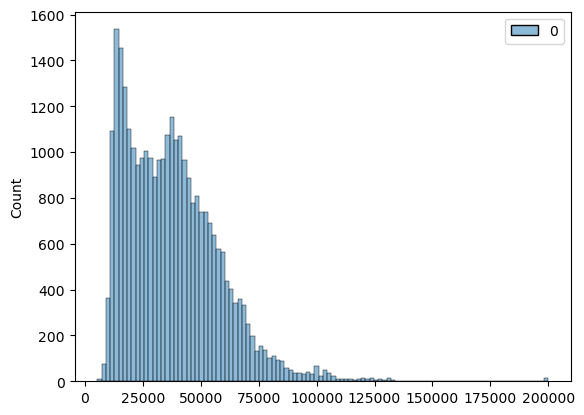

In [60]:
sns.histplot(np.clip(np.exp(bestmodel.predict(X_val)), a_min=0, a_max=200000))

<Axes: xlabel='price', ylabel='Count'>

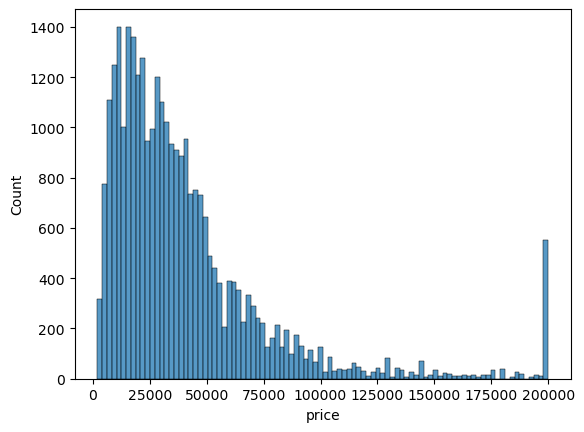

In [59]:
sns.histplot(np.clip(y_val, a_min=0, a_max=200000))

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial_id = best_trial.trial_id
metrics = tuner.oracle.get_trial(best_trial_id).metrics

In [ ]:
list(best_trial.metrics.metrics.keys())

['loss',
 'mean_squared_error',
 'val_loss',
 'val_mean_squared_error',
 'learning_rate']

In [ ]:
metrics_dict = {
    metric: best_trial.metrics.get_last_value(metric)
    for metric in best_trial.metrics.metrics.keys()
}
metrics_dict

{'loss': 0.3098580837249756,
 'mean_squared_error': 0.3098580837249756,
 'val_loss': 0.2818891406059265,
 'val_mean_squared_error': 0.2818891406059265,
 'learning_rate': 0.0044999998062849045}

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rf.fit(X_train, np.log(y_train))
rf.score(X_val, np.log(y_val))

0.5595888488717837